In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import iqr
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
def get_cat_num_features(df):
    num_features = []
    cat_features = []
    for col in df.columns:
        if df[col].dtype=="float64" or df[col].dtype=="int64":
            num_features.append(col)
        else:
            cat_features.append(col)
    return num_features, cat_features
def get_outliers(df, num_feat):
    outlier_df = pd.DataFrame(columns=['Feature', 'Total Outliers','Upper limit', 'Lower limit'])
    for col in num_feat:
        lower=np.percentile(df[col],25)-(1.5*iqr(df[col]))
        upper=np.percentile(df[col],75)+(1.5*iqr(df[col]))
        upper_outliers = df[df[col] > upper]
        lower_outliers = df[df[col] < lower]
        total=lower_outliers.shape[0]+upper_outliers.shape[0]
        if (total!=0) and (upper!=0 and lower!=0):
            outlier_df = outlier_df.append({'Feature':col, 'Total Outliers': total,'Upper limit': upper, 'Lower limit':lower}, ignore_index=True)
    return outlier_df
def remove_outliers(df, outlier_df, num_feat):
    for col in outlier_df['Feature'].to_list():
        upper = outlier_df[outlier_df['Feature']== col ]['Upper limit'].values[0]
        lower = outlier_df[outlier_df['Feature']== col ]['Lower limit'].values[0]
        df[col] = np.where(df[col]>upper, upper, df[col])
        df[col] = np.where(df[col]<lower, lower, df[col])
    return df

In [3]:
data=pd.read_csv('train.csv', index_col='Id')
data2=pd.read_csv('test.csv', index_col='Id')
temp=data['SalePrice']
data=data.drop(['SalePrice'],axis=1)
data=pd.concat([data,data2])

In [4]:
data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml


In [5]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [6]:
nulls = data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

MSZoning 4
LotFrontage 486
Alley 2721
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 24
MasVnrArea 23
BsmtQual 81
BsmtCond 82
BsmtExposure 82
BsmtFinType1 79
BsmtFinSF1 1
BsmtFinType2 80
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
Electrical 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 1420
GarageType 157
GarageYrBlt 159
GarageFinish 159
GarageCars 1
GarageArea 1
GarageQual 159
GarageCond 159
PoolQC 2909
Fence 2348
MiscFeature 2814
SaleType 1


In [7]:
data=data.fillna({'Alley':'NA','BsmtQual':'NA','BsmtCond':'NA','BsmtExposure':'NA','BsmtFinType1':'NA','BsmtFinType2':'NA','FireplaceQu':'NA','GarageType':'NA','GarageFinish':'NA','GarageQual':'NA','GarageCond':'NA','PoolQC':'NA','Fence':'NA','MiscFeature':'NA','Exterior2nd':'NA','Functional':'Typ'})
cate=['MSZoning','Exterior1st','MasVnrType','Electrical','KitchenQual','Functional','GarageYrBlt','SaleType']
for item in cate:
    data[item]=data[item].fillna(data[item].value_counts().index[0])
data=data.drop(['Utilities'],axis=1)
data=data.drop(['KitchenAbvGr'],axis=1)
tem=np.where(data['MasVnrType']=='None',0,data['MasVnrArea'])
data['MasVnrArea']=data['MasVnrArea'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType1']=='NA',0,data['BsmtFinSF1'])
data['BsmtFinSF1']=data['BsmtFinSF1'].fillna(pd.Series(tem))
tem=np.where(data['BsmtFinType2']=='NA',0,data['BsmtFinSF2'])
data['BsmtFinSF2']=data['BsmtFinSF2'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtUnfSF'])
data['BsmtUnfSF']=data['BsmtUnfSF'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtHalfBath'])
data['BsmtHalfBath']=data['BsmtHalfBath'].fillna(pd.Series(tem))
tem=np.where(data['BsmtQual']=='NA',0,data['BsmtFullBath'])
data['BsmtFullBath']=data['BsmtFullBath'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageCars'])
data['GarageCars']=data['GarageCars'].fillna(pd.Series(tem))
tem=np.where(data['GarageType']=='NA',0,data['GarageArea'])
data['GarageArea']=data['GarageArea'].fillna(pd.Series(tem))
data['LotFrontage']=data.groupby('Neighborhood')["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data['TotalBsmtSF']=(data['BsmtFinSF1']+data['BsmtFinSF2']+data['BsmtUnfSF'])
data['TotalSF']=data['TotalBsmtSF']+data['1stFlrSF']+data['2ndFlrSF']
data['Total_sqr_footage'] = (data['BsmtFinSF1']+data['BsmtFinSF2']+data['1stFlrSF']+data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath'])+data['BsmtFullBath']+(0.5*data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF']+data['3SsnPorch']+data['EnclosedPorch'] + data['ScreenPorch']+data['WoodDeckSF'])
data=data.drop(columns=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','2ndFlrSF','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF'])
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)
tem=np.where(data['YrSold']>data['GarageYrBlt'],data['YrSold'],np.where(data['GarageYrBlt']>data['YearRemodAdd'],data['GarageYrBlt'],data['YearRemodAdd']))
data['age']=tem-data['YearBuilt']
data['YearRemodAdd']=data['YearRemodAdd'].astype(str)
data['YearBuilt']=data['YearBuilt'].astype(str)
data['GarageYrBlt']=data['GarageYrBlt'].astype(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
od=['MSZoning','LotShape','LandContour','LandSlope','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual', 'GarageCond', 'PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']
dm=['MSSubClass','Street','Alley','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation','Heating']
data=pd.get_dummies(data,columns=dm)
num_feat,cat_feat=get_cat_num_features(data)
outlier_df = get_outliers(data, num_feat)
data=remove_outliers(data,outlier_df,num_feat)
for col in data.select_dtypes('object').columns:
    if col in od:
        le=LabelEncoder()
        data[col]=le.fit_transform(data[col])
    else:
        continue
data2=data.iloc[1460:,:]
data=data.iloc[0:1460,:]
data=data.join(temp)
outlier_df
data.head(10)

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,3,65.0,8450.0,3,3,0,7.0,4,2003,2003,...,0,0,0,0,1,0,0,0,0,208500
2,3,80.0,9600.0,3,3,0,6.0,7,1976,1976,...,0,0,0,0,1,0,0,0,0,181500
3,3,68.0,11250.0,0,3,0,7.0,4,2001,2002,...,0,0,0,0,1,0,0,0,0,223500
4,3,60.0,9550.0,0,3,0,7.0,4,1915,1970,...,0,0,0,0,1,0,0,0,0,140000
5,3,84.0,14260.0,0,3,0,8.0,4,2000,2000,...,0,0,0,0,1,0,0,0,0,250000
6,3,85.0,14115.0,0,3,0,5.0,4,1993,1995,...,0,0,1,0,1,0,0,0,0,143000
7,3,75.0,10084.0,3,3,0,8.0,4,2004,2005,...,0,0,0,0,1,0,0,0,0,307000
8,3,80.0,10382.0,0,3,0,7.0,5,1973,1973,...,0,0,0,0,1,0,0,0,0,200000
9,4,51.0,6120.0,3,3,0,7.0,4,1931,1950,...,0,0,0,0,1,0,0,0,0,129900


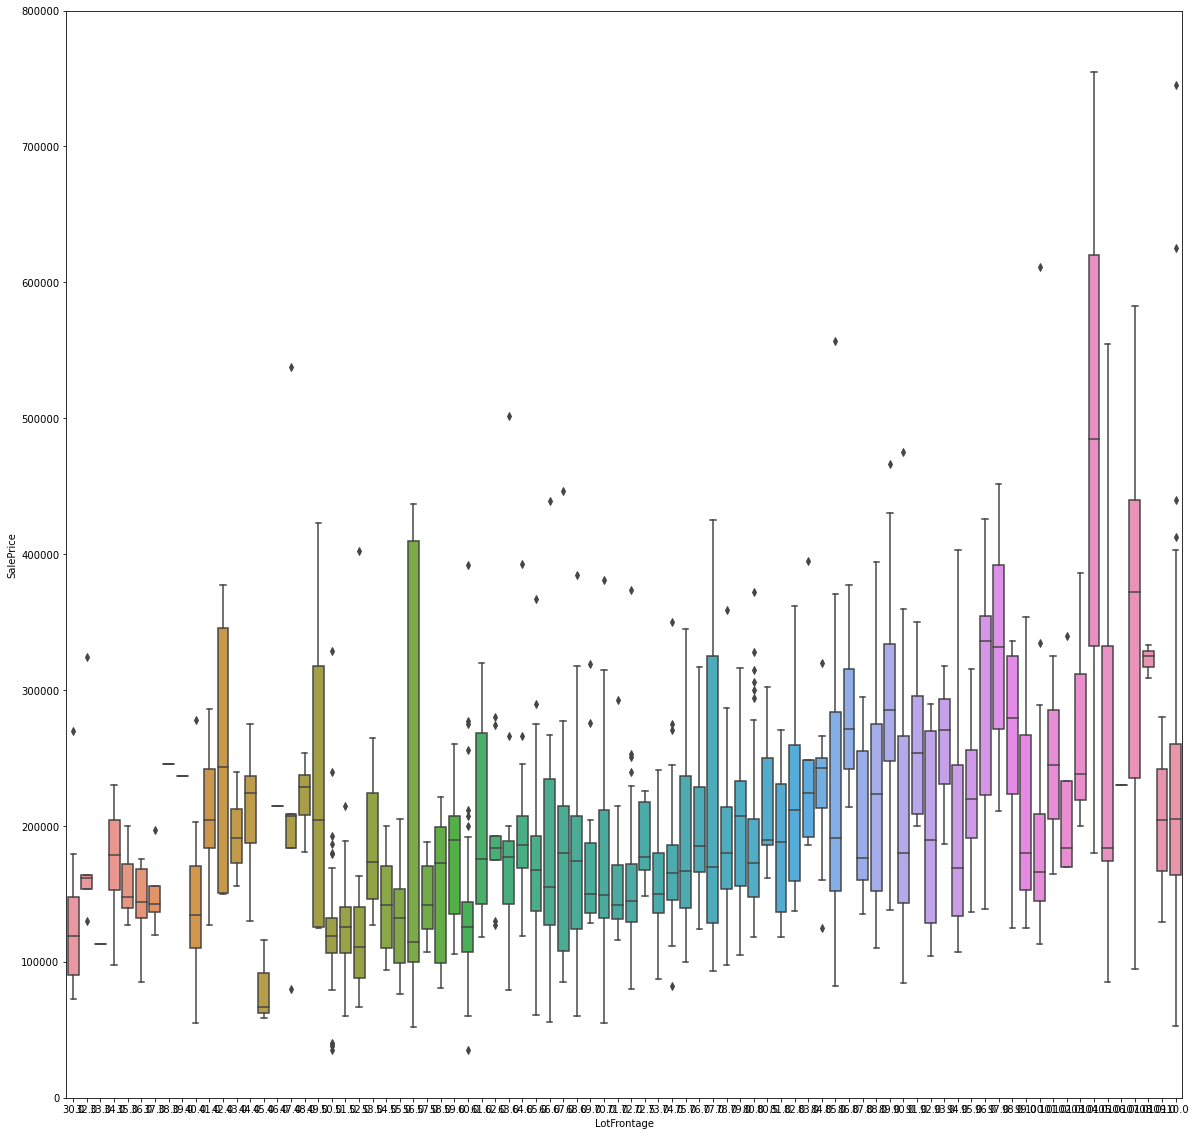

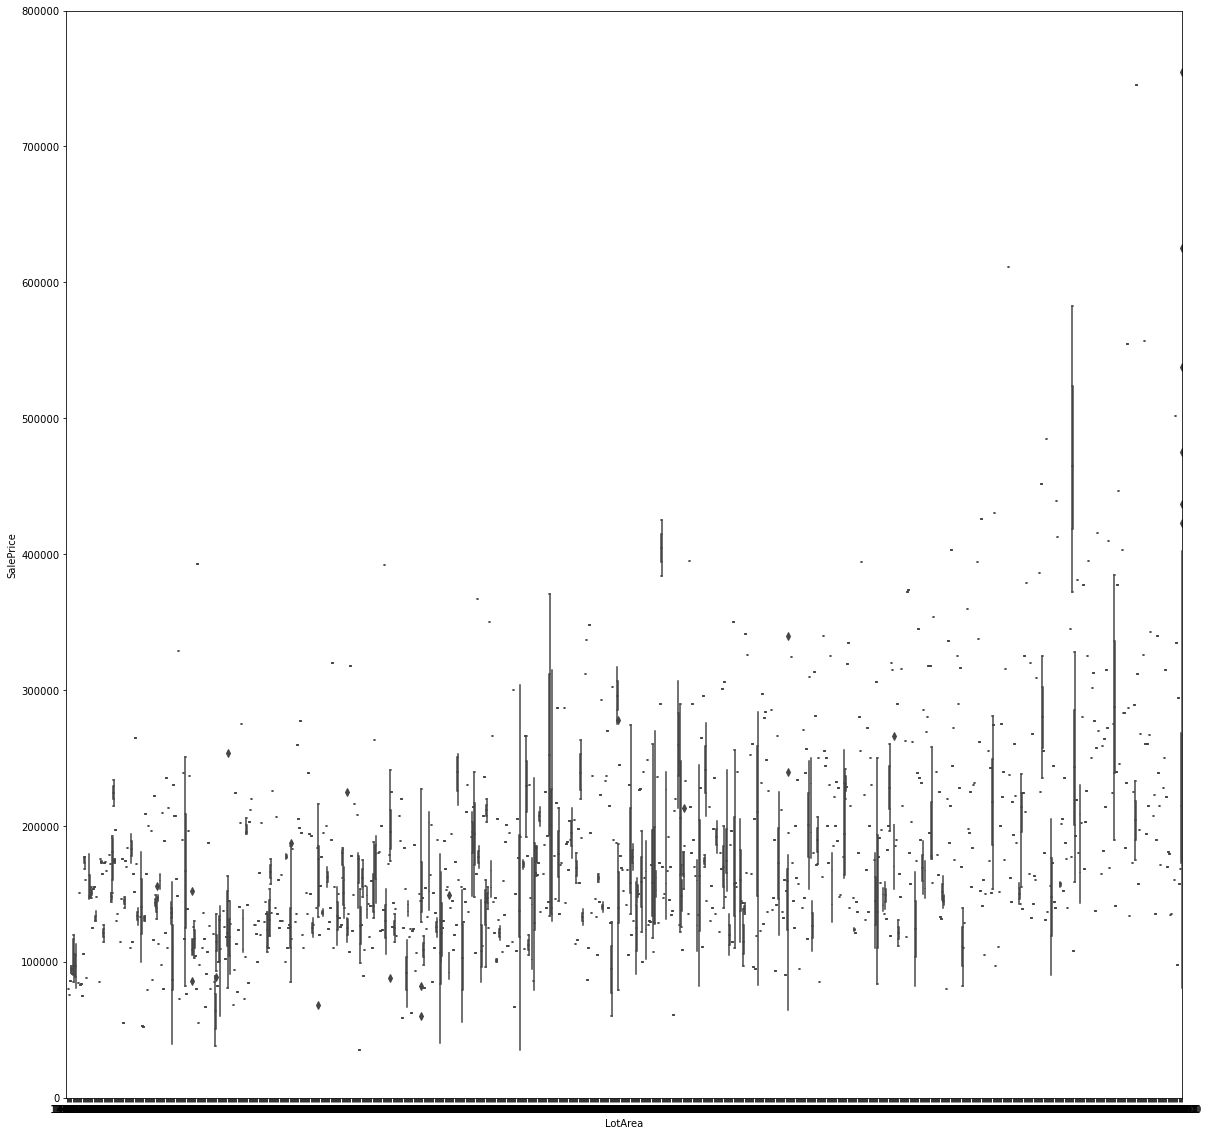

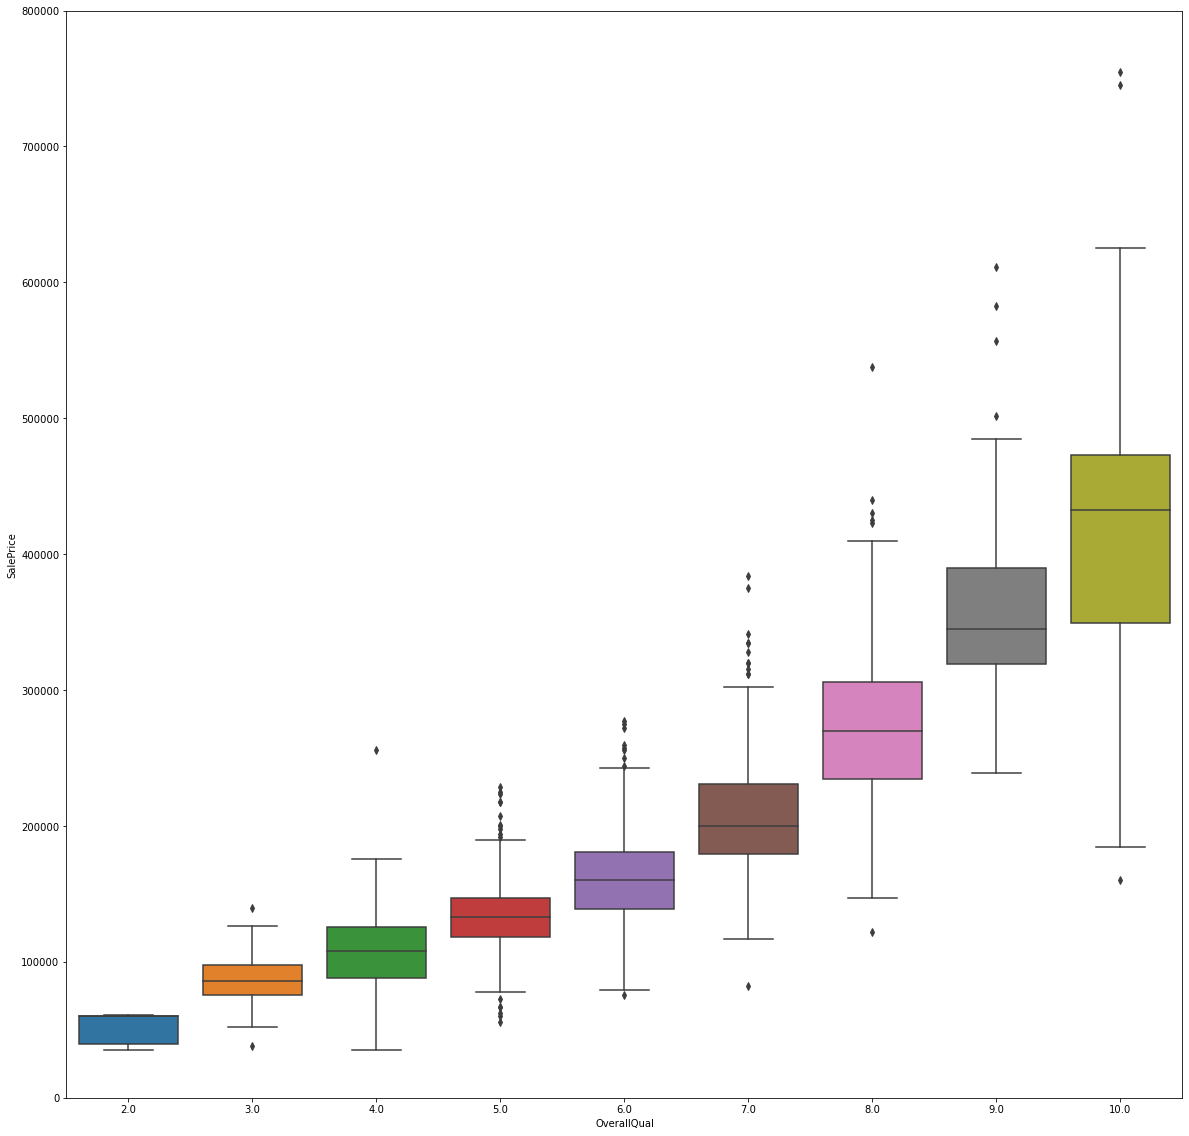

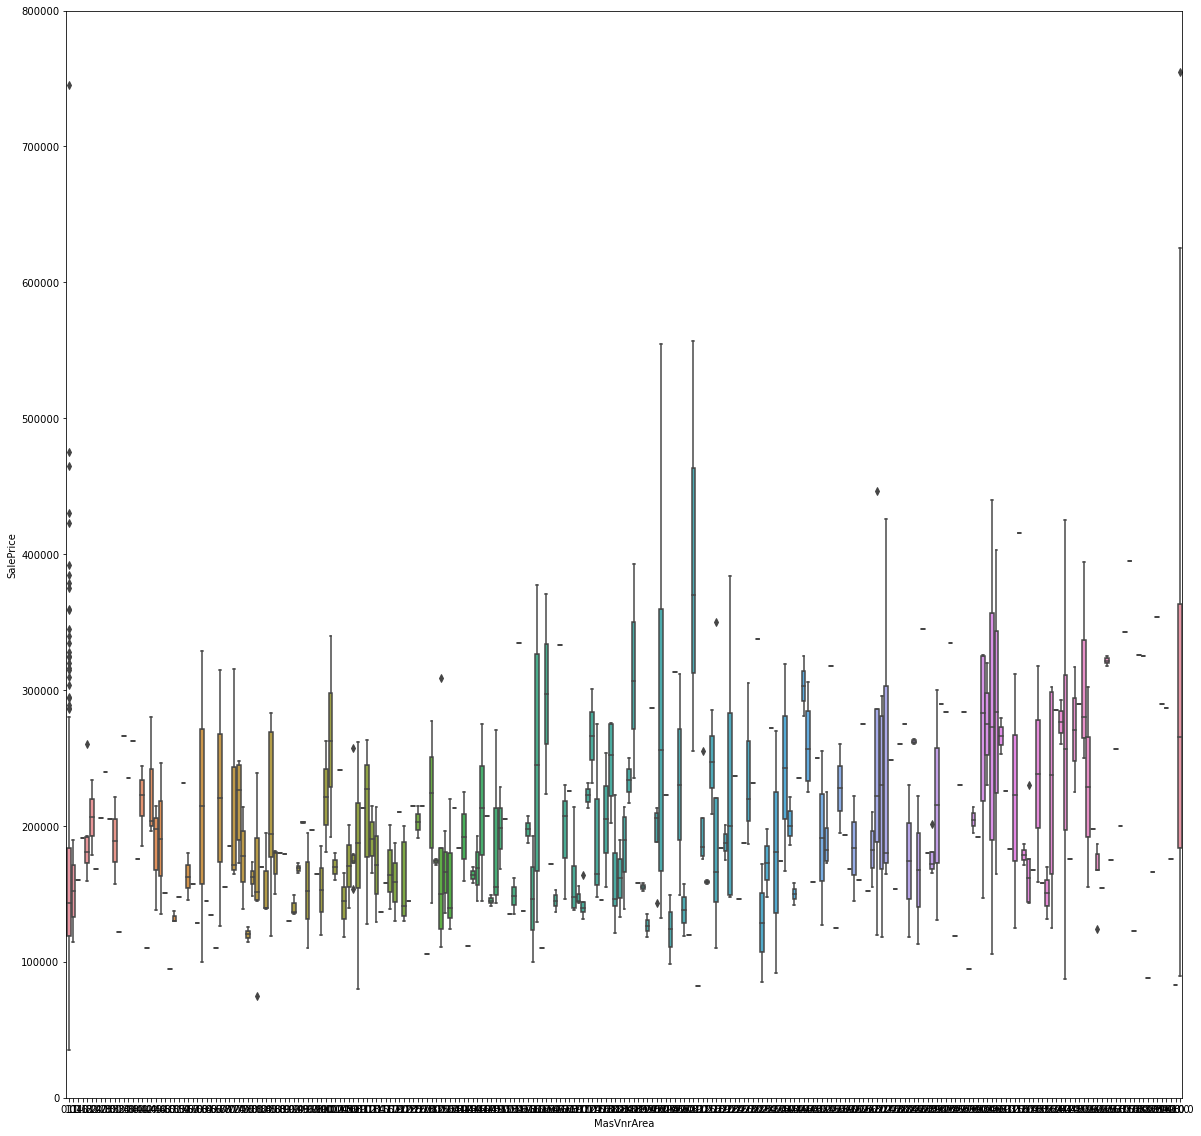

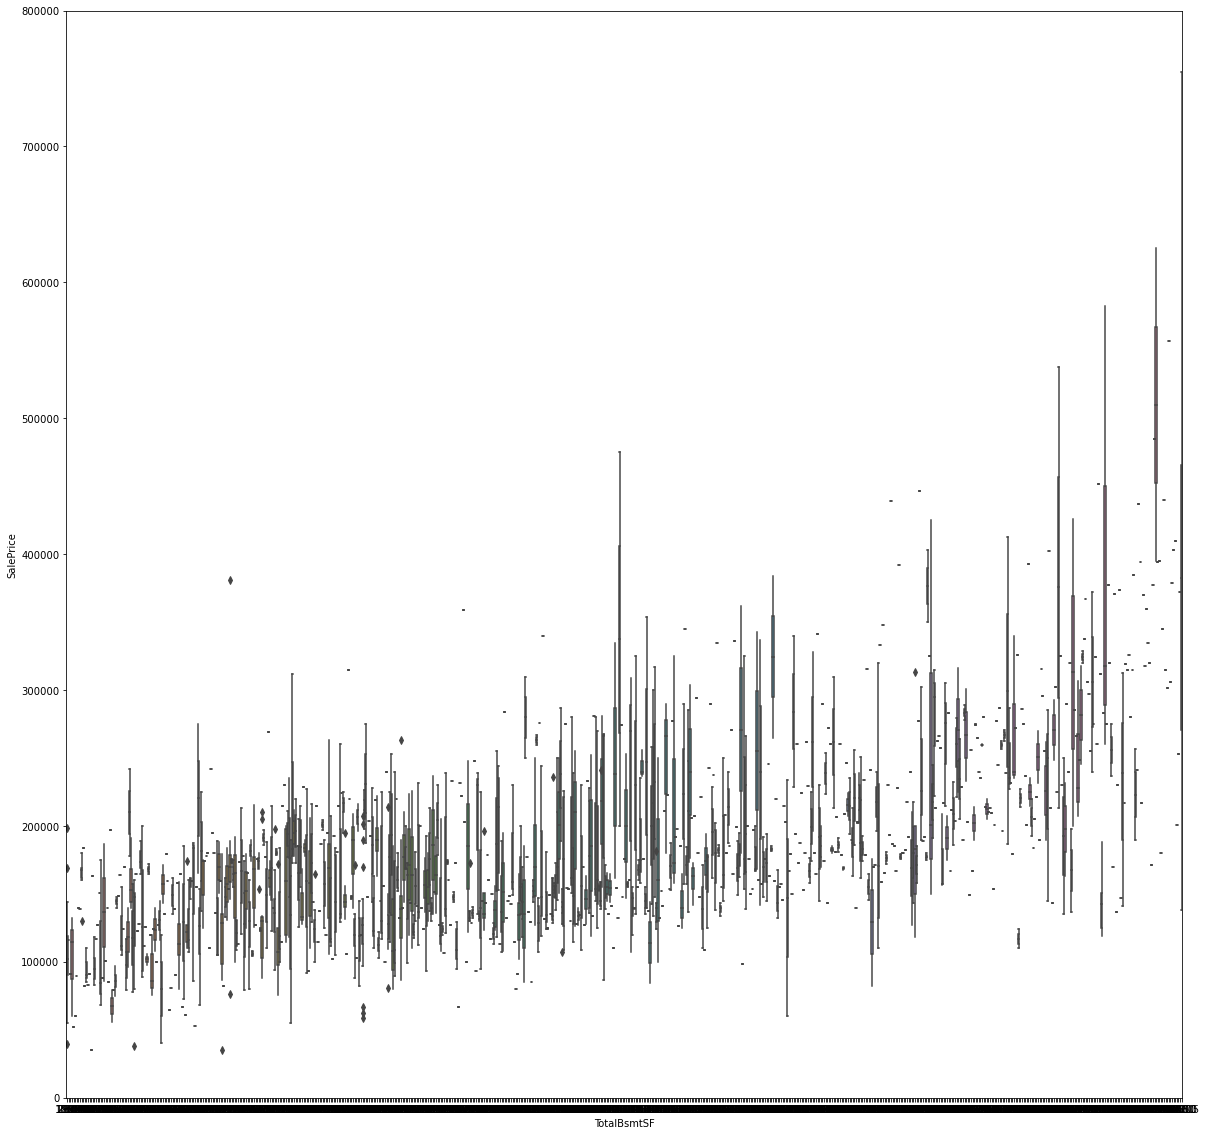

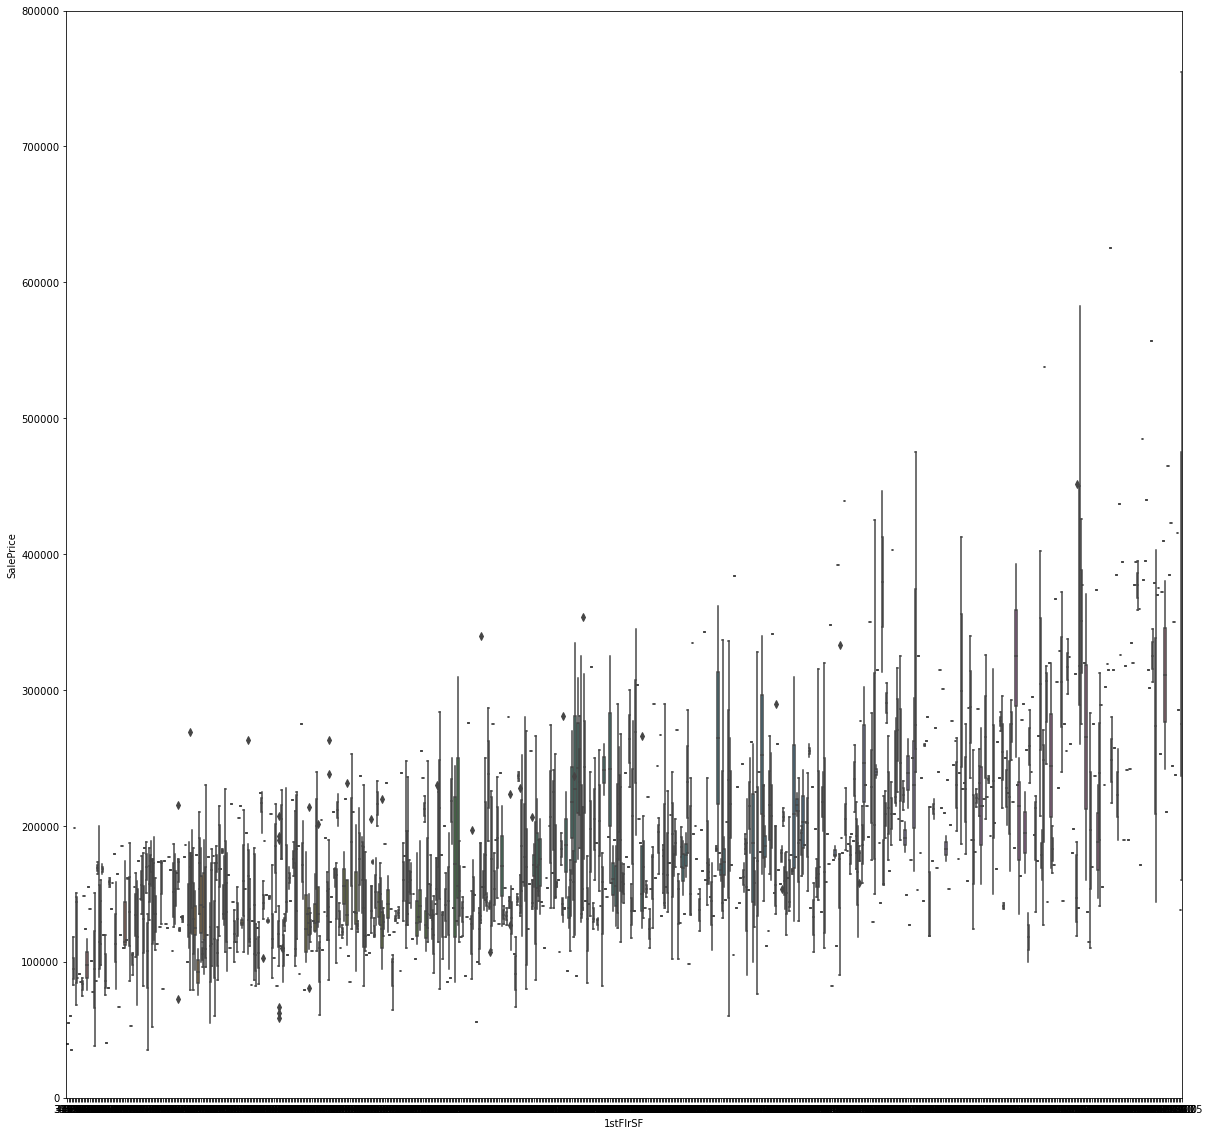

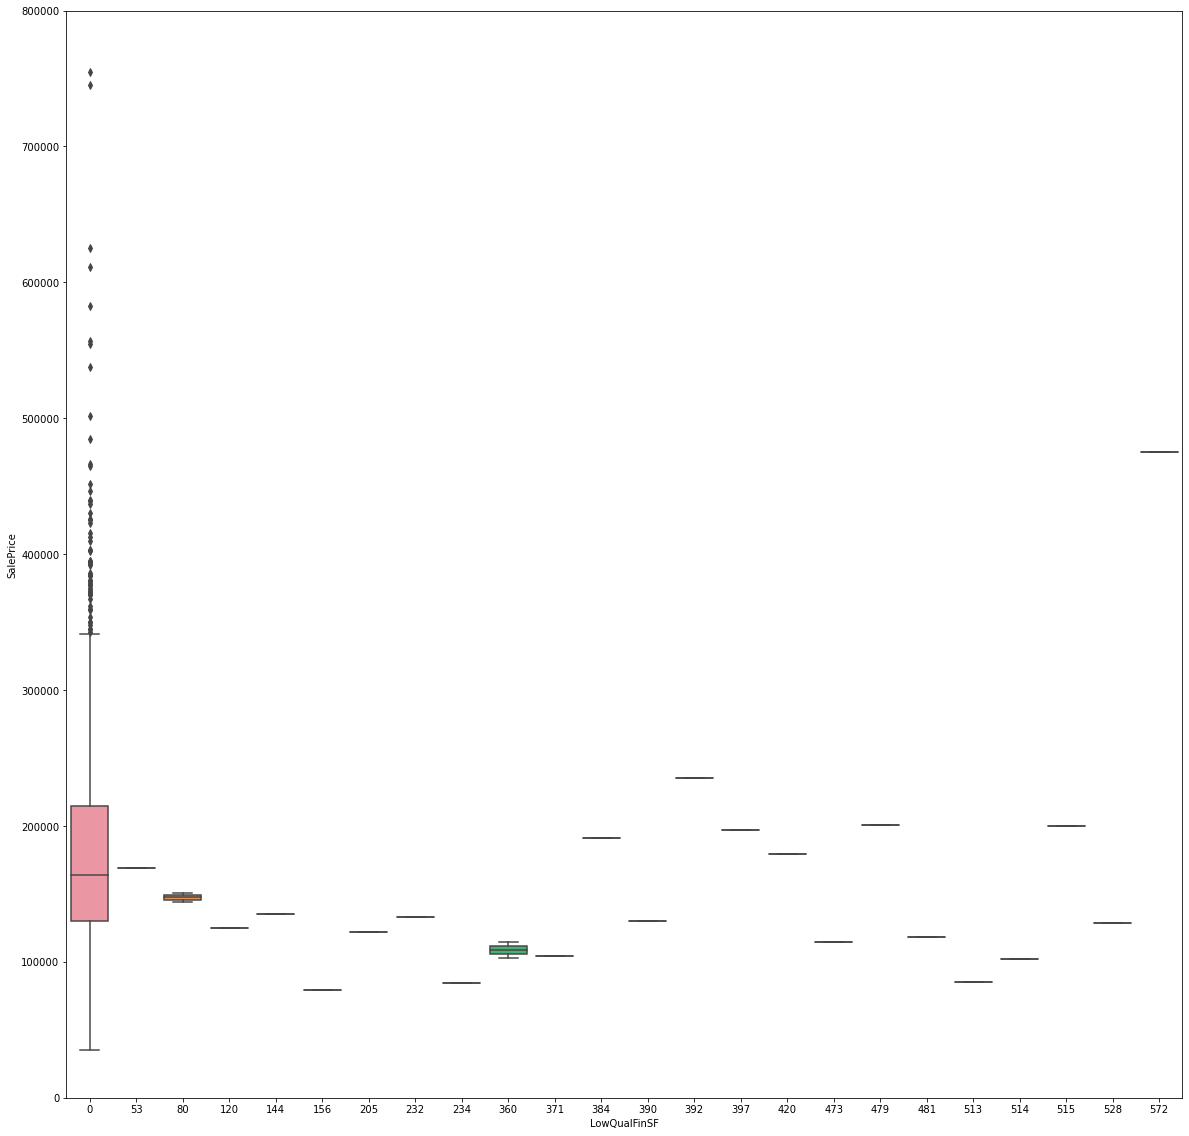

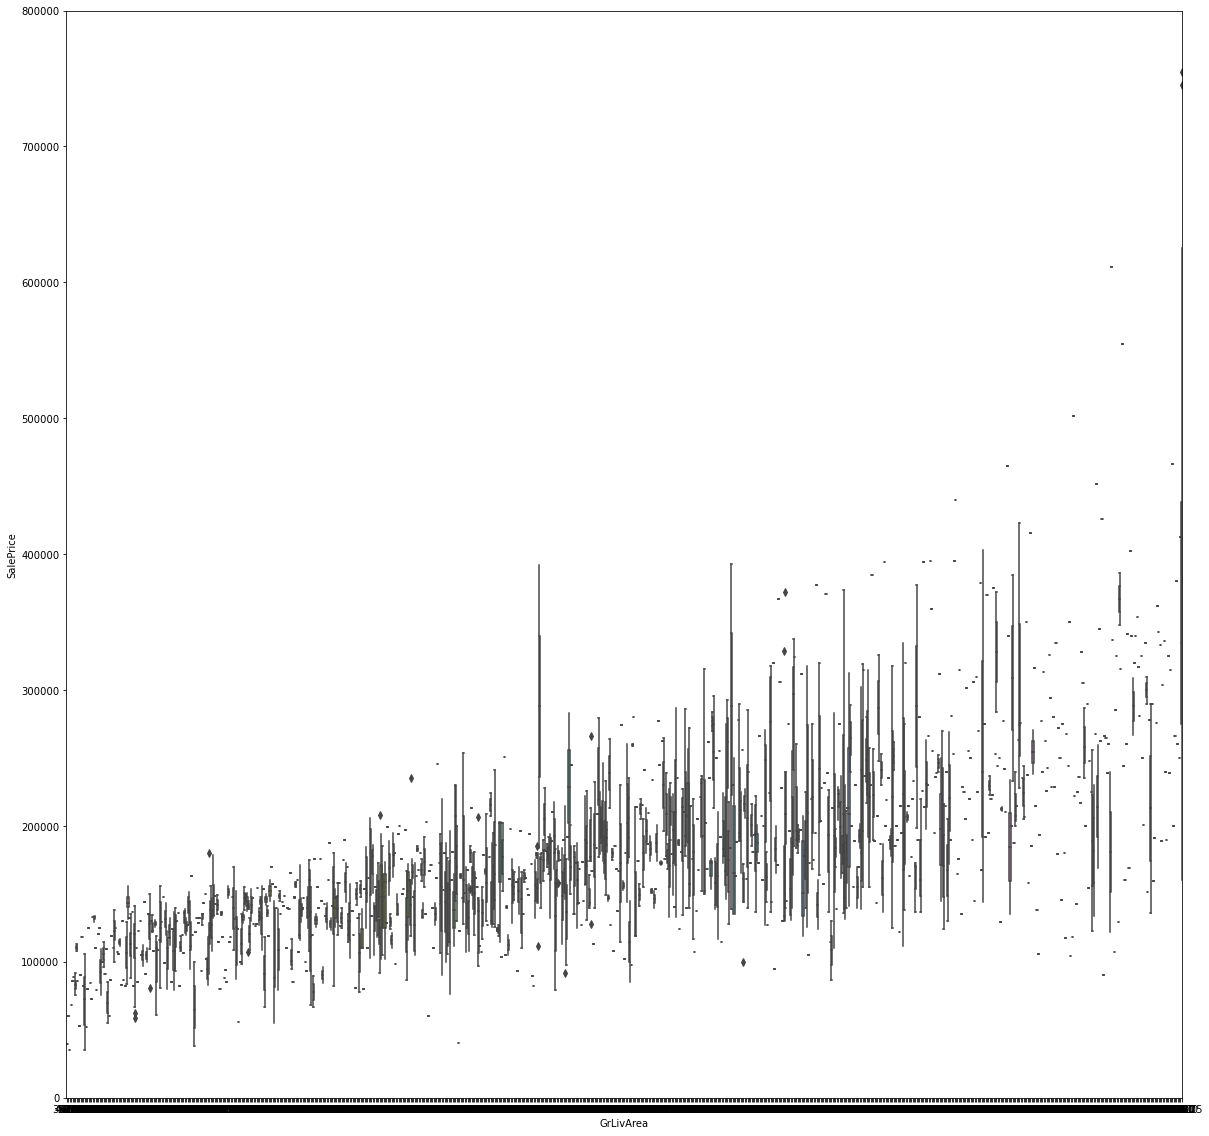

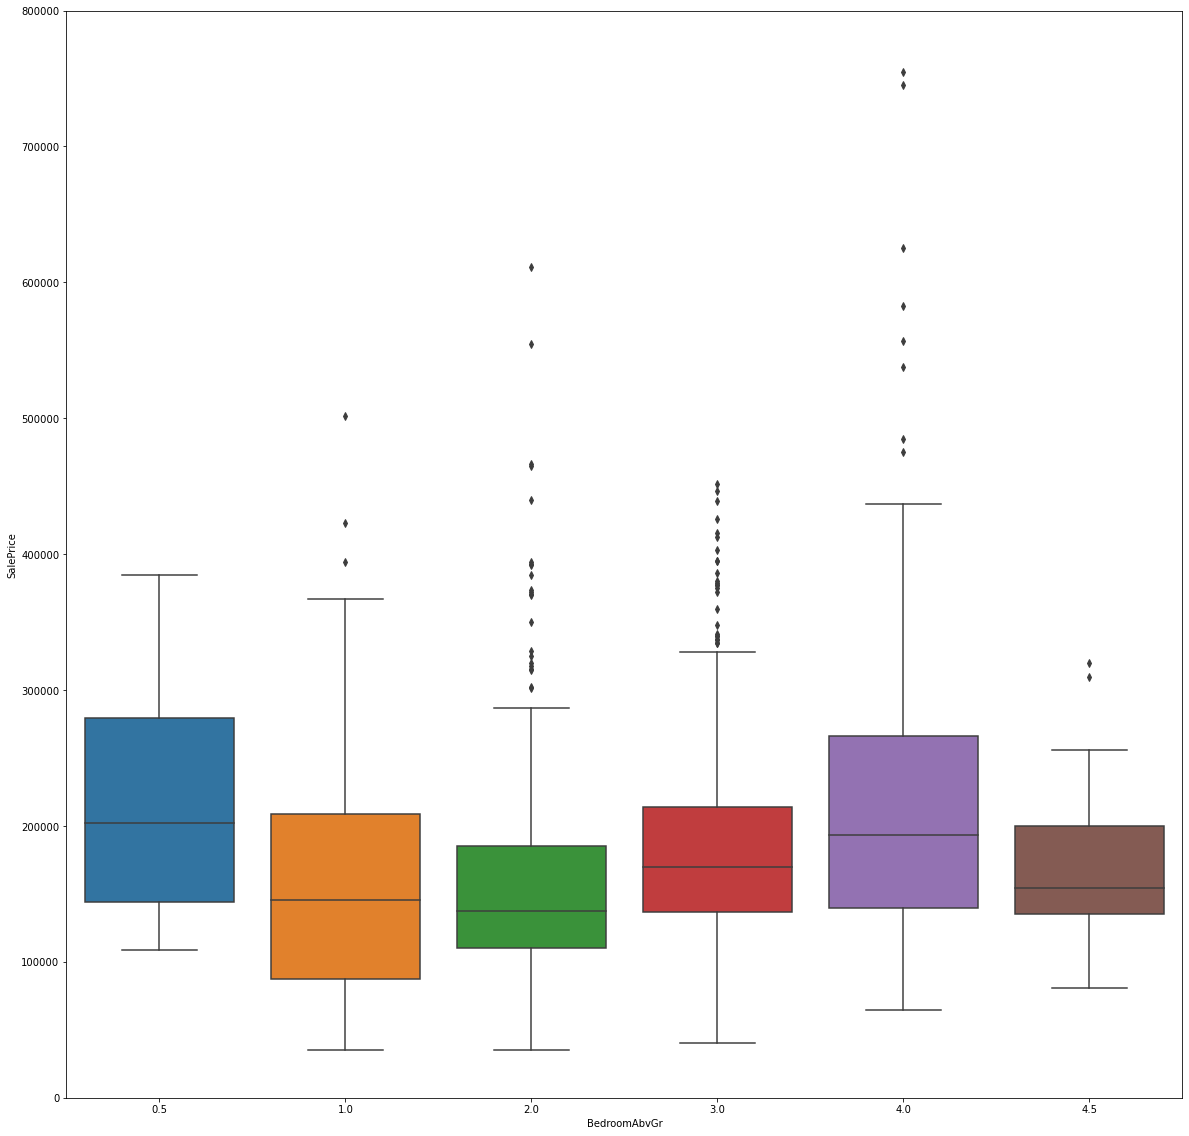

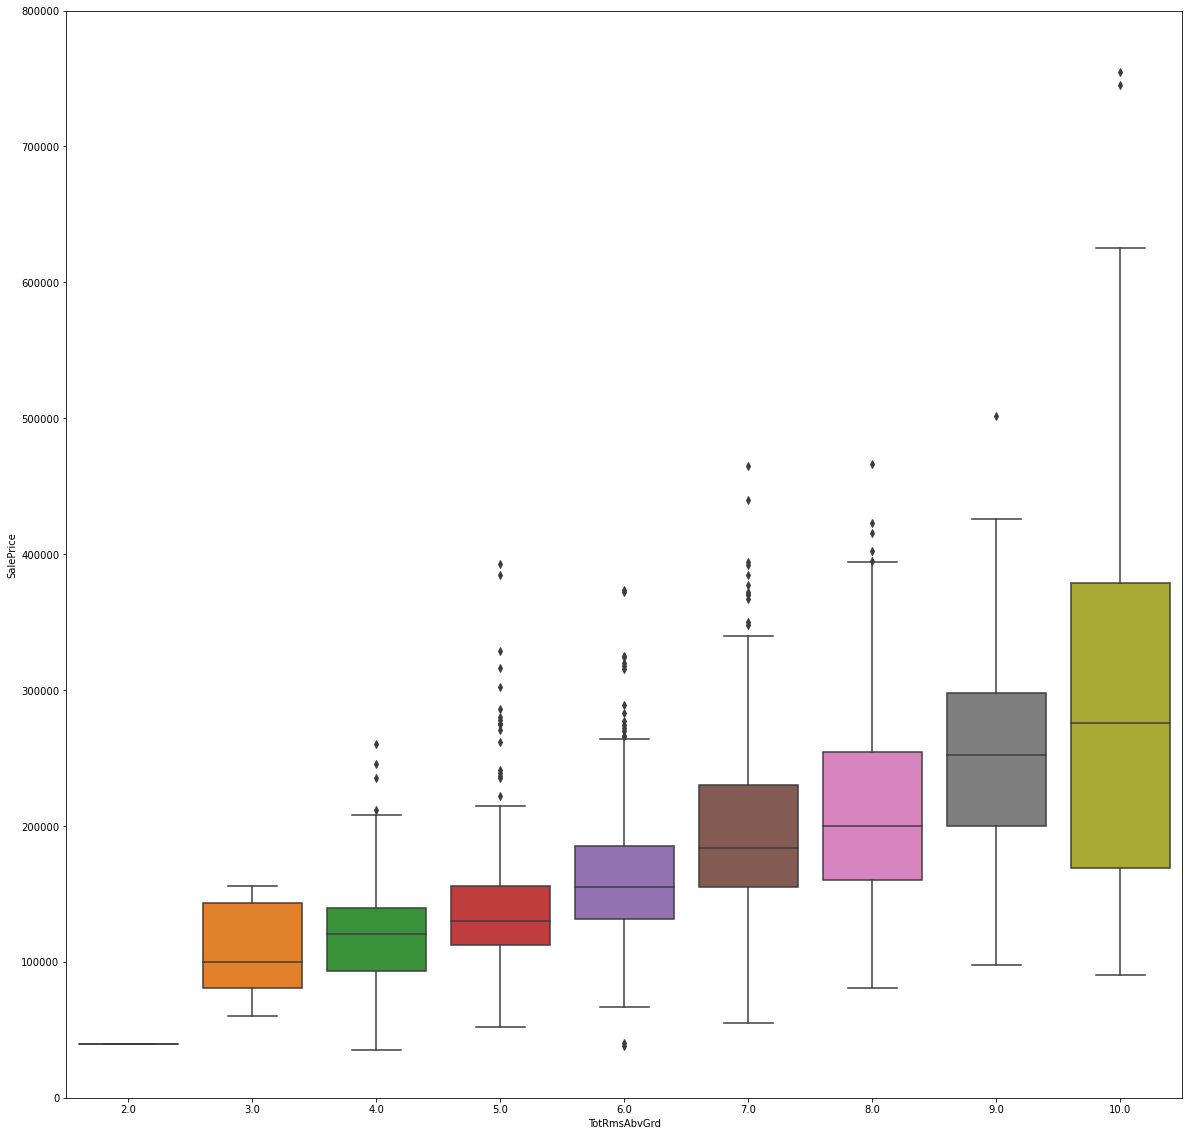

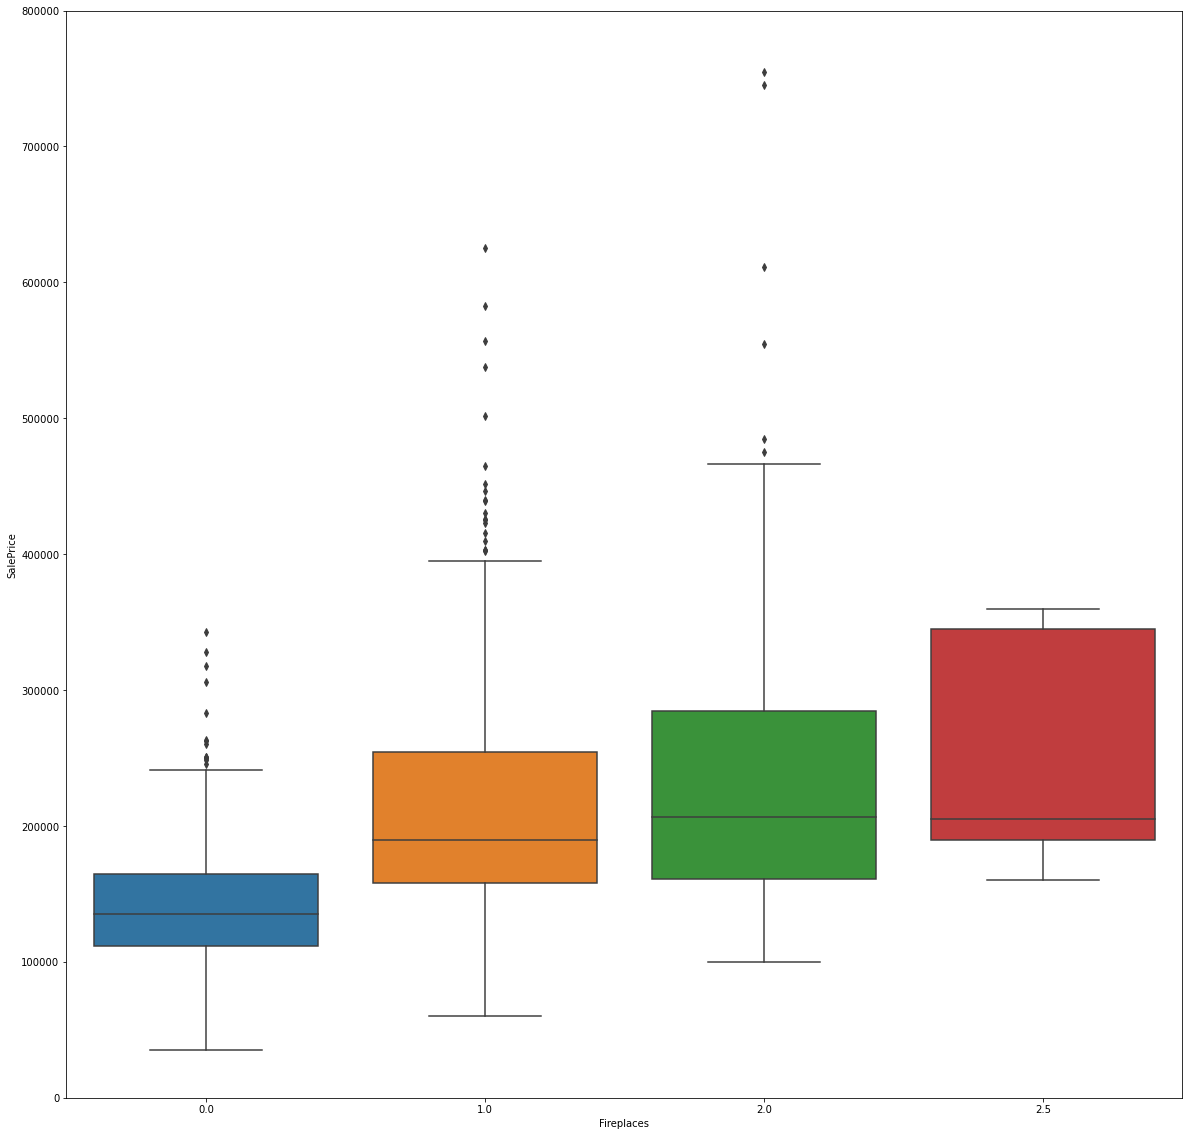

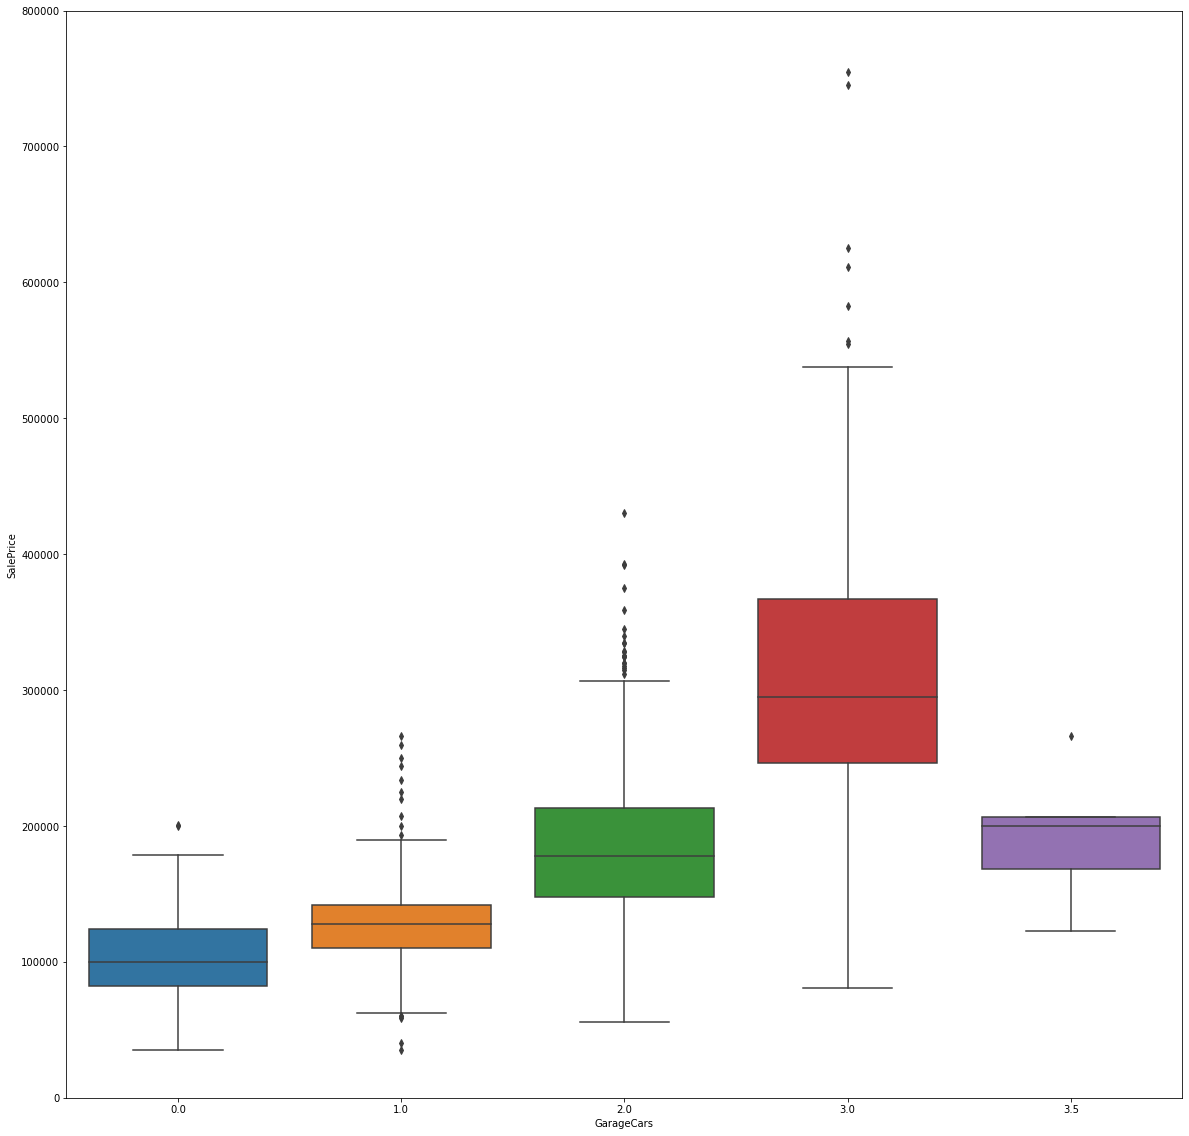

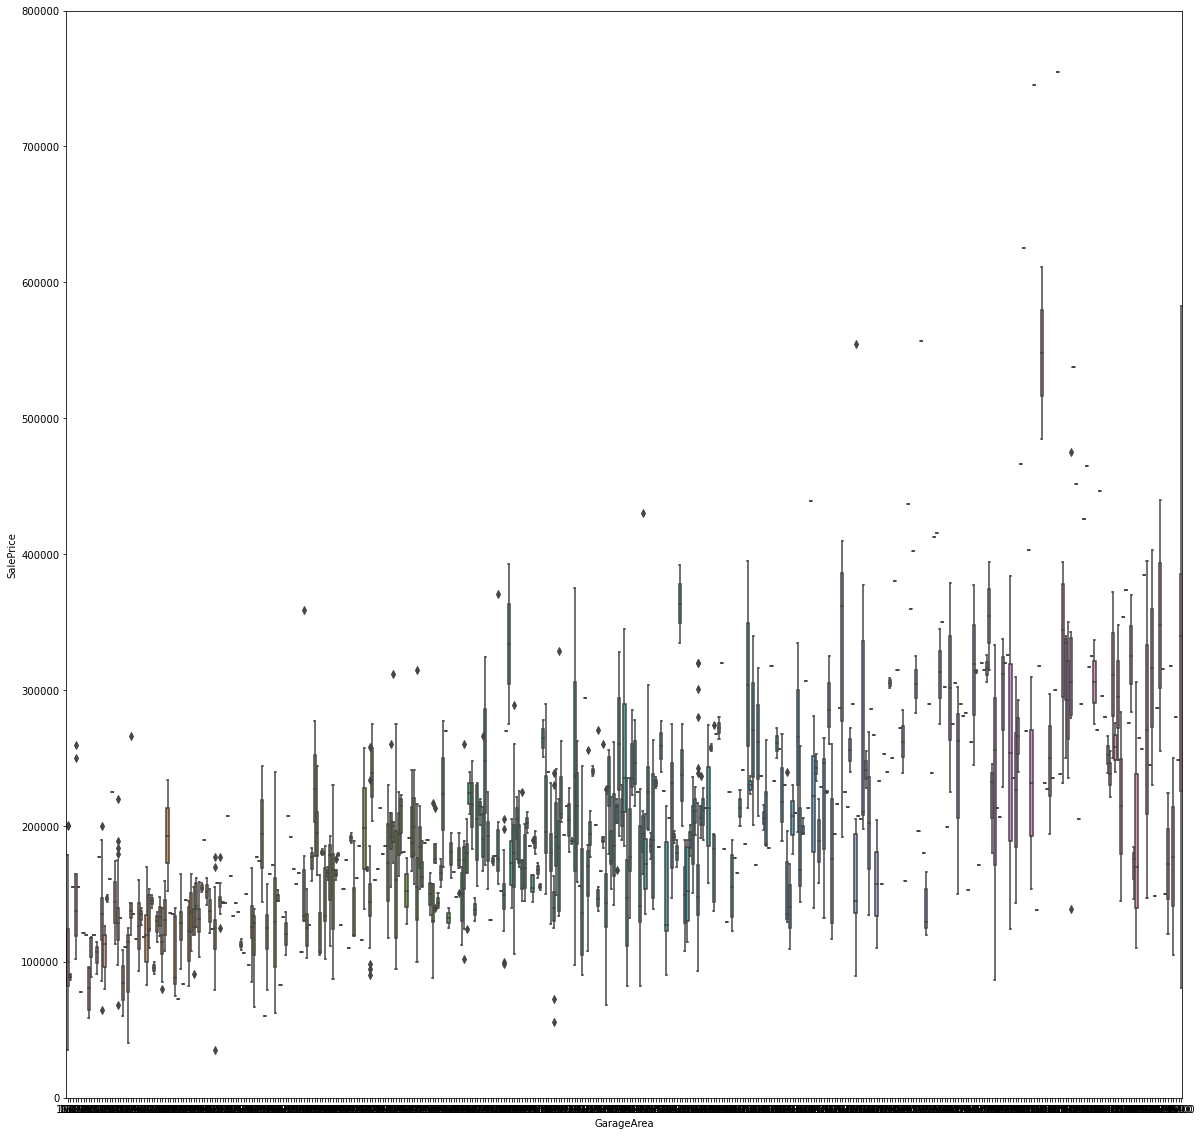

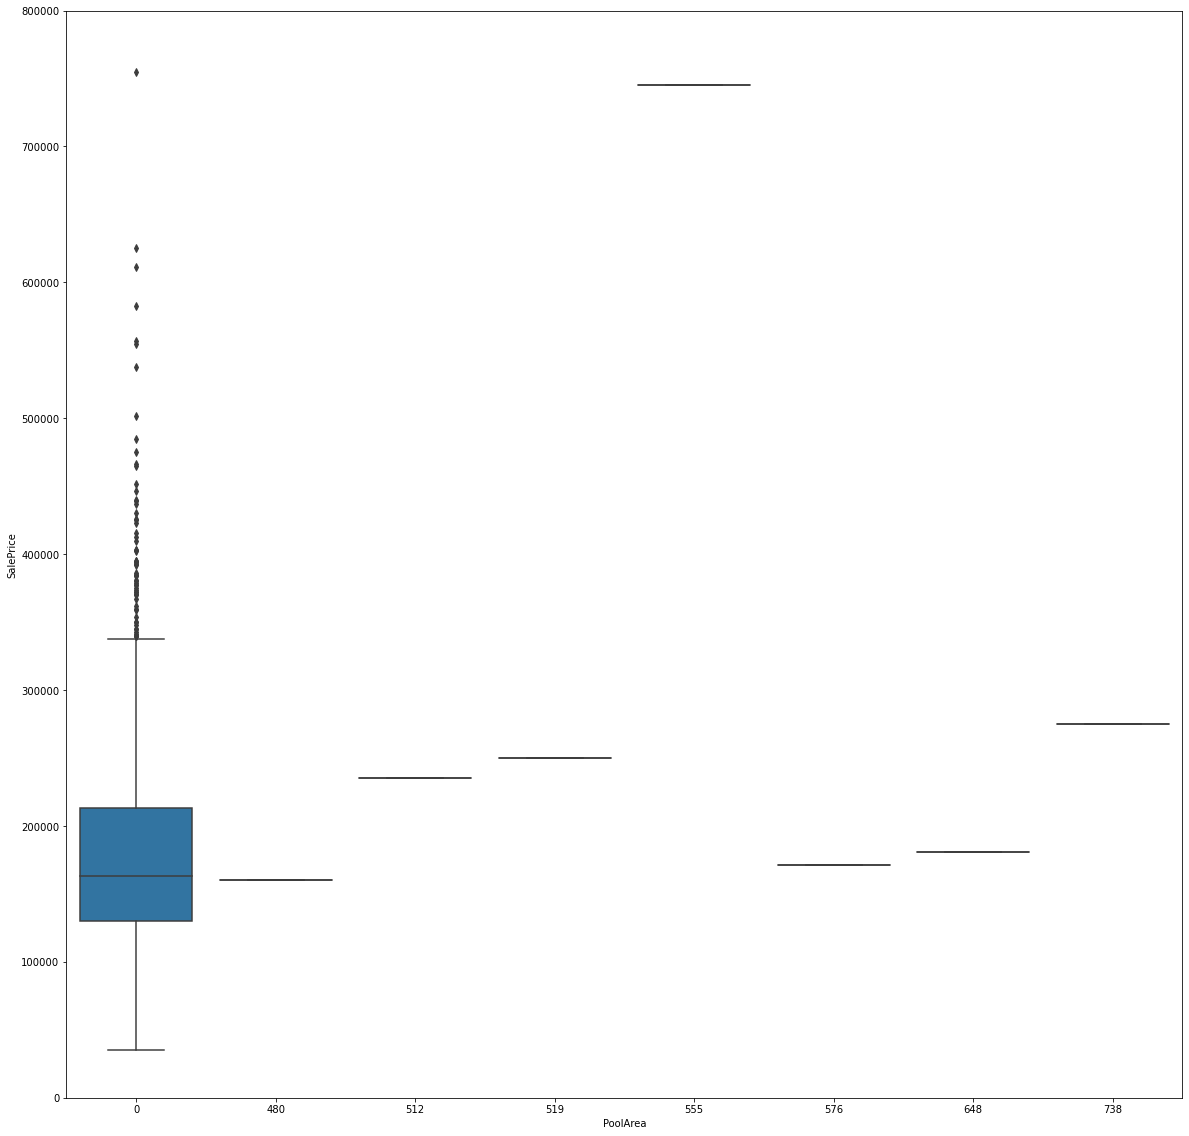

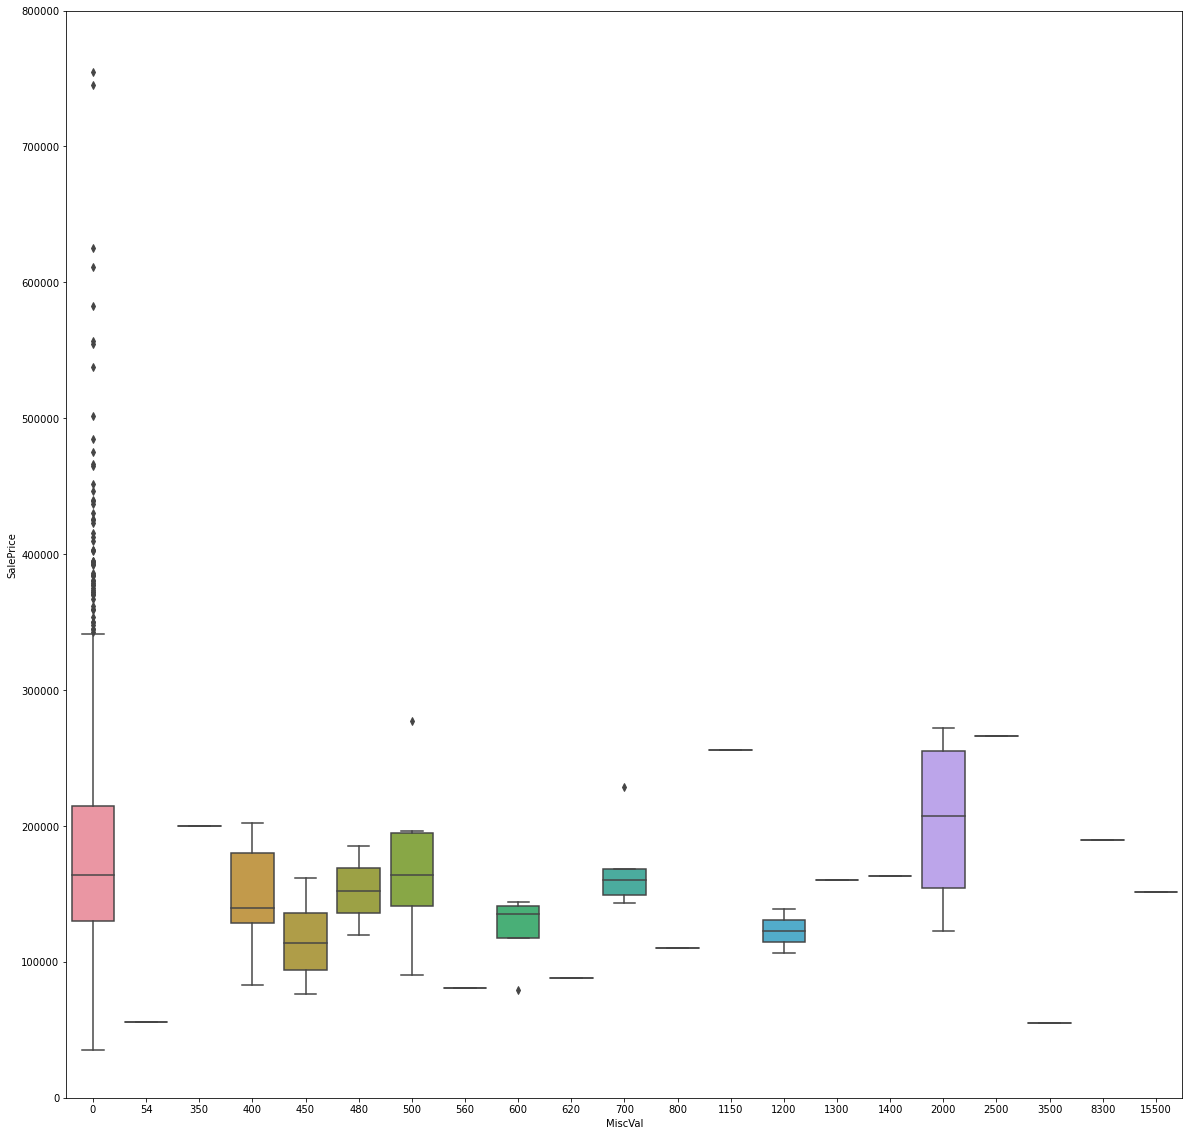

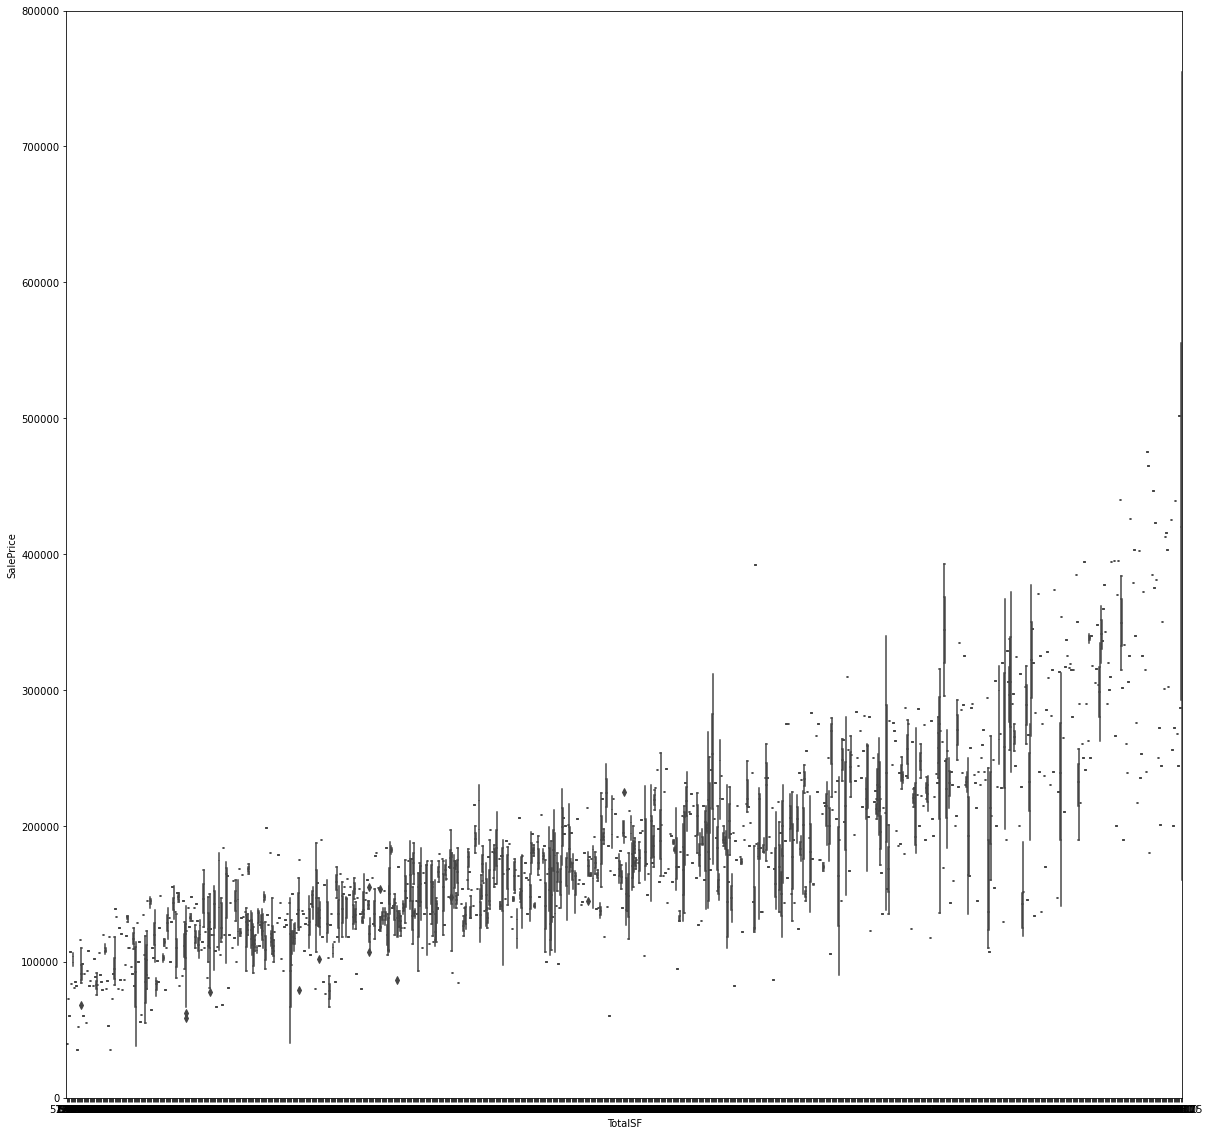

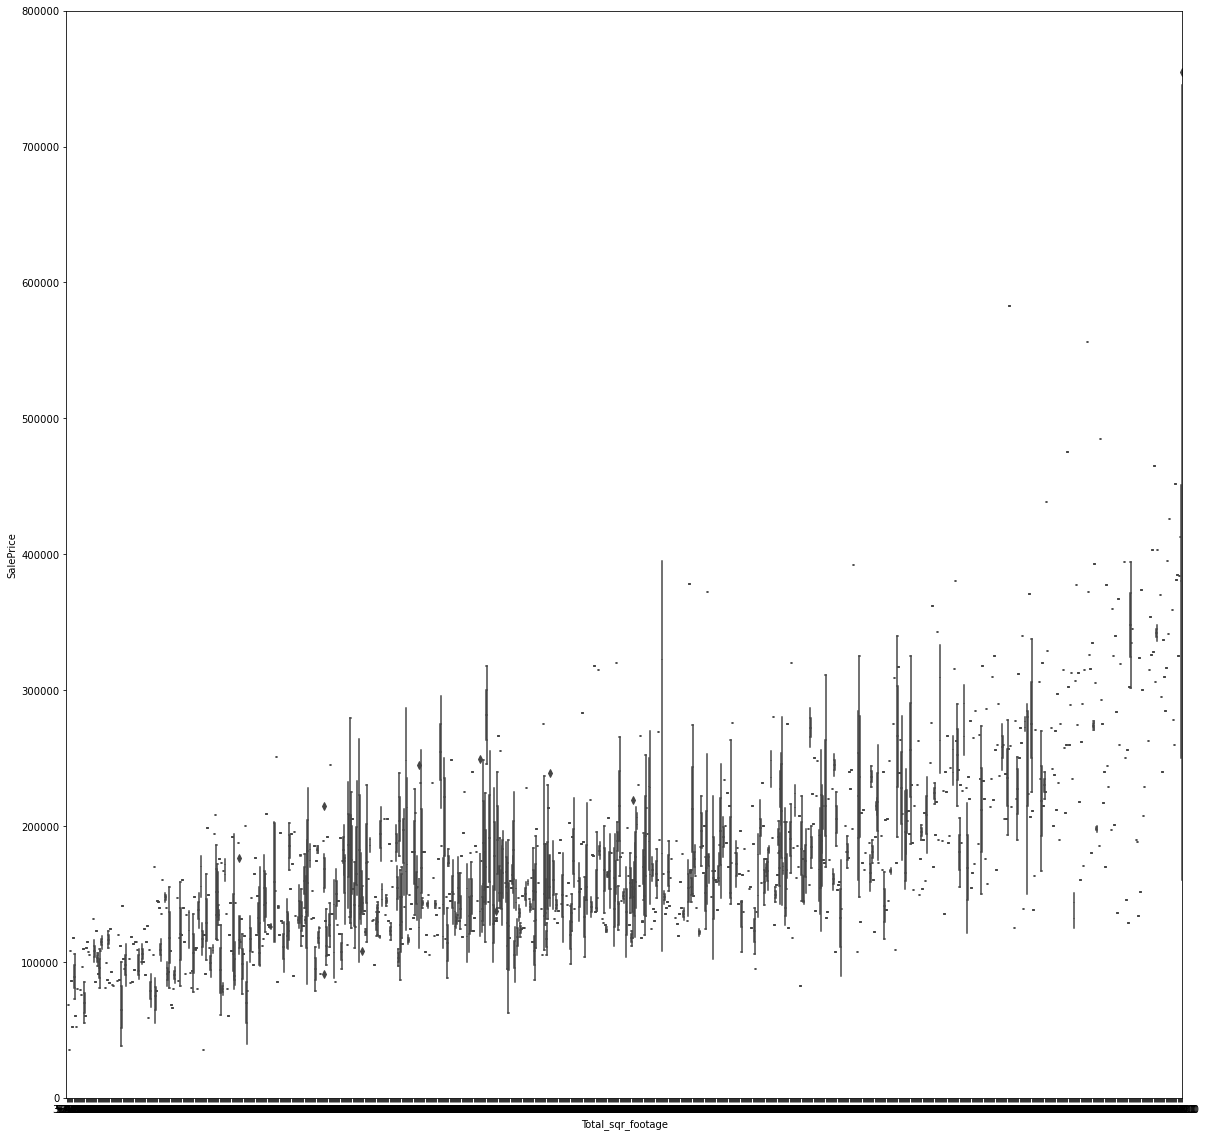

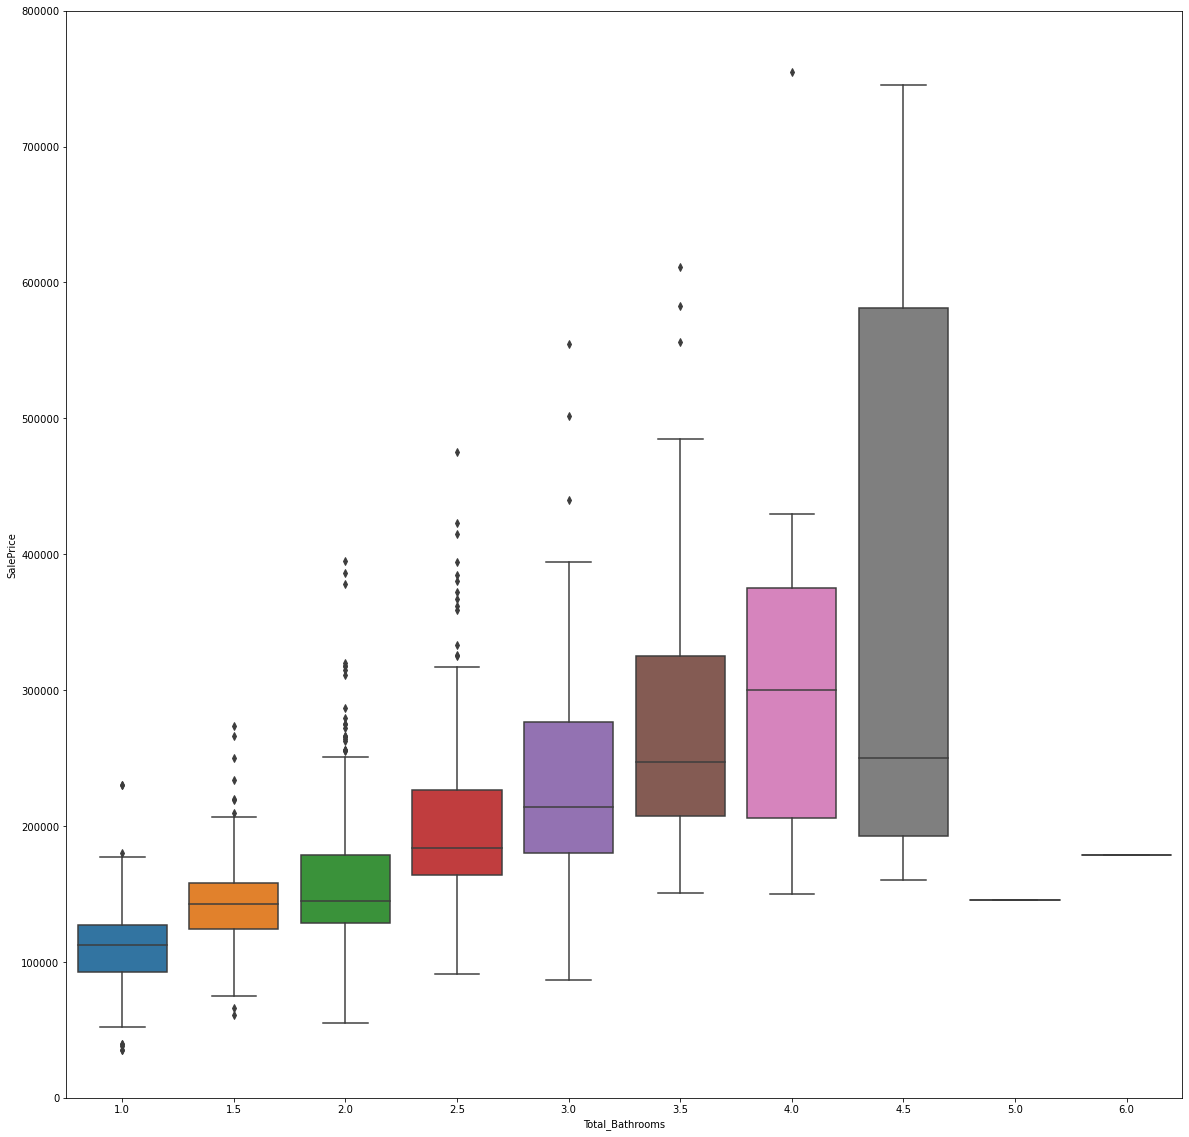

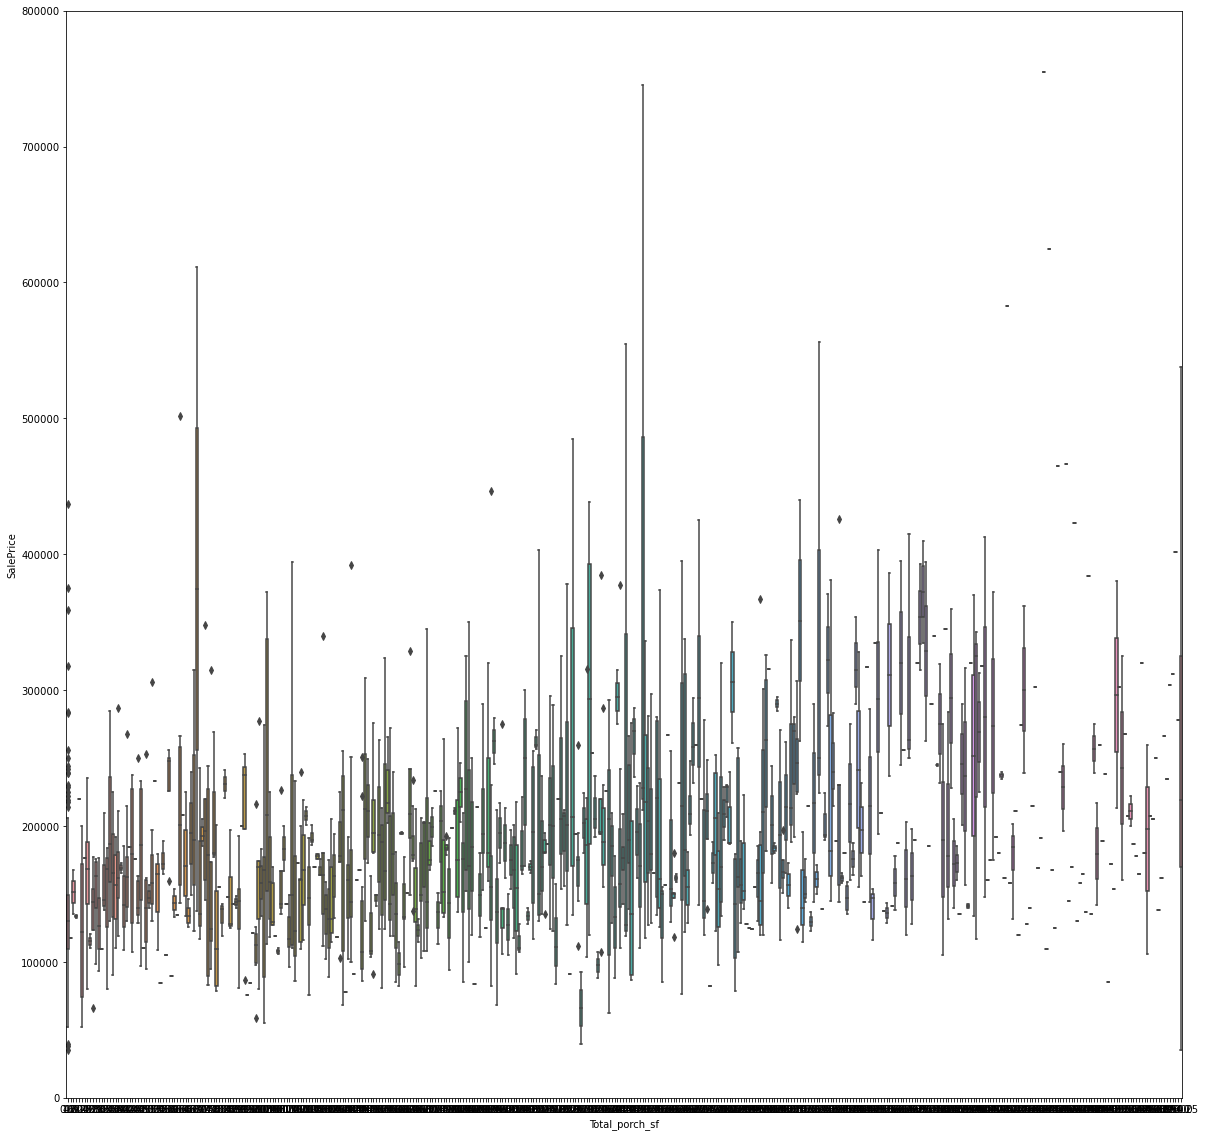

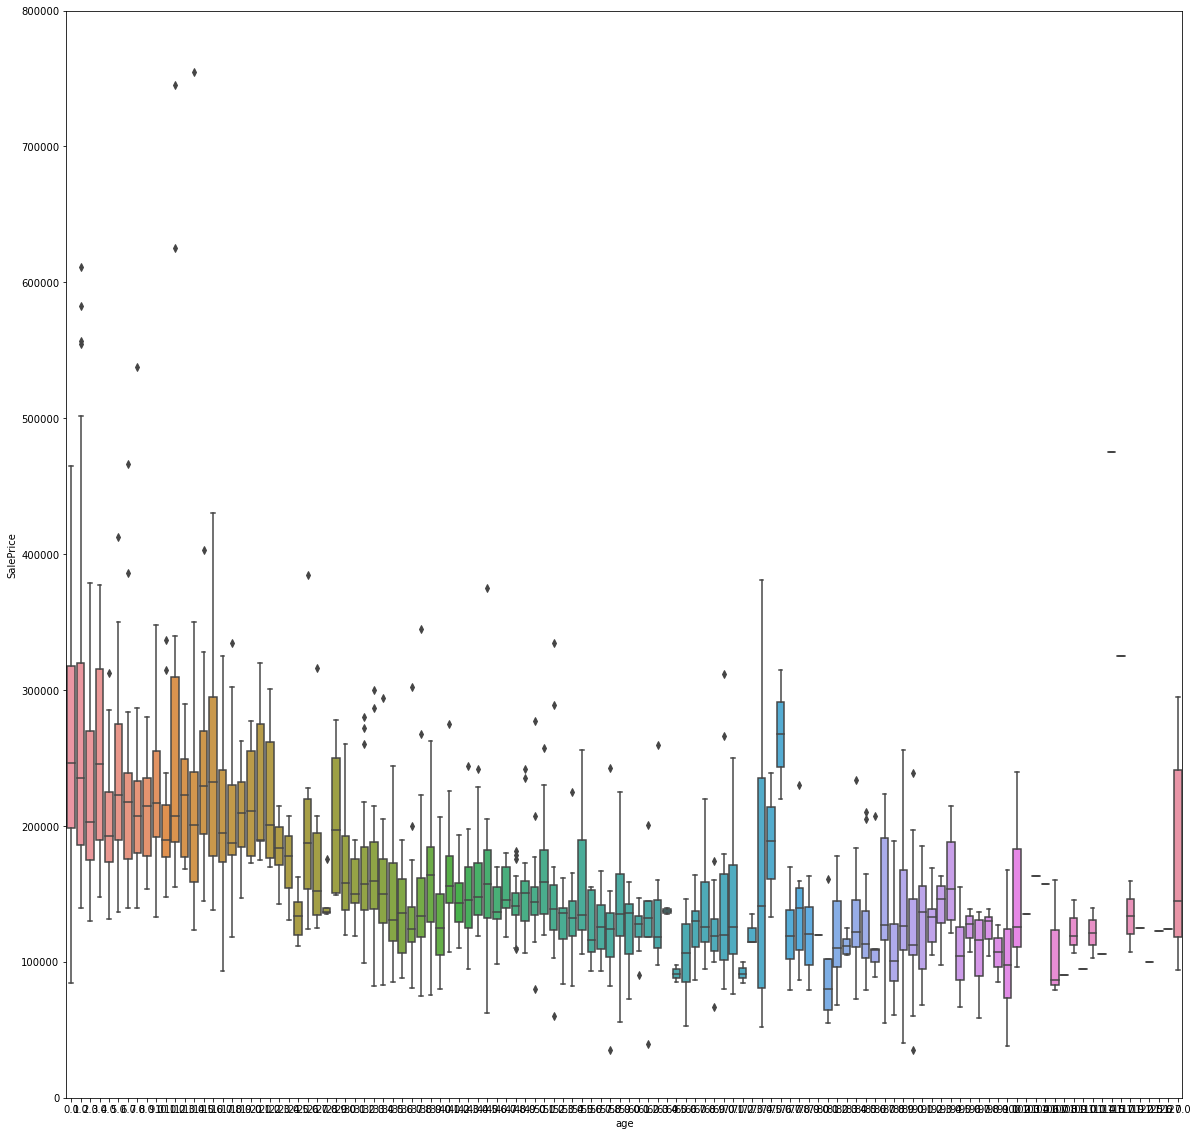

In [12]:
for col in num_feat:
    df = pd.concat([data['SalePrice'], data[col]], axis=1)
    f, ax = plt.subplots(figsize=(20, 20))
    fig = sns.boxplot(x=data[col], y="SalePrice", data=df)
    fig.axis(ymin=0, ymax=800000);

In [13]:
data.describe()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,3.028767,69.468151,9648.871233,1.942466,2.777397,0.062329,6.100685,4.575342,89.795205,2.539726,...,0.016438,0.004110,0.002055,0.000685,0.978082,0.012329,0.004795,0.001370,0.002740,180921.195890
std,0.632017,18.024406,3598.128683,1.409156,0.707666,0.276232,1.378430,1.112799,134.181252,0.693995,...,0.127198,0.063996,0.045299,0.026171,0.146465,0.110386,0.069100,0.036999,0.052289,79442.502883
min,0.000000,30.000000,1340.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,3.000000,60.000000,7553.500000,0.000000,3.000000,0.000000,5.000000,4.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,3.000000,70.000000,9478.500000,3.000000,3.000000,0.000000,6.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,3.000000,80.000000,11601.500000,3.000000,3.000000,0.000000,7.000000,5.000000,166.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,4.000000,110.000000,17708.000000,3.000000,3.000000,2.000000,10.000000,8.000000,410.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,755000.000000


In [14]:
outlier_df

,Feature,Total Outliers,Upper limit,Lower limit
0,LotFrontage,206,110.00,30.00
1,LotArea,128,17708.00,1340.00
2,OverallQual,4,10.00,2.00
3,MasVnrArea,201,410.00,-246.00
4,TotalBsmtSF,122,2065.50,29.50
5,1stFlrSF,42,2154.75,108.75
6,GrLivArea,74,2669.75,199.75
7,BedroomAbvGr,78,4.50,0.50
8,TotRmsAbvGrd,51,10.00,2.00
9,Fireplaces,12,2.50,-1.50


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
c=data.corr()
y=data.iloc[:,-1]

In [16]:
#check correlation
print(c[c['SalePrice']>=0.49]['SalePrice'].sort_values())

Foundation_PConc     0.497734
TotRmsAbvGrd         0.536067
1stFlrSF             0.620735
GarageArea           0.630409
Total_Bathrooms      0.631731
TotalBsmtSF          0.637019
GarageCars           0.644002
GrLivArea            0.705647
Total_sqr_footage    0.725249
OverallQual          0.791965
TotalSF              0.805128
SalePrice            1.000000
Name: SalePrice, dtype: float64


In [17]:
print(c[c['SalePrice']<=-0.49]['SalePrice'].sort_values())

ExterQual     -0.636884
BsmtQual      -0.593734
KitchenQual   -0.589189
age           -0.523835
Name: SalePrice, dtype: float64


In [18]:
x = data[['Foundation_PConc', 'TotRmsAbvGrd', 'GarageArea', 
          'Total_Bathrooms','TotalBsmtSF', 'GarageCars', 'GrLivArea', 
          'Total_sqr_footage','OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

<AxesSubplot:>

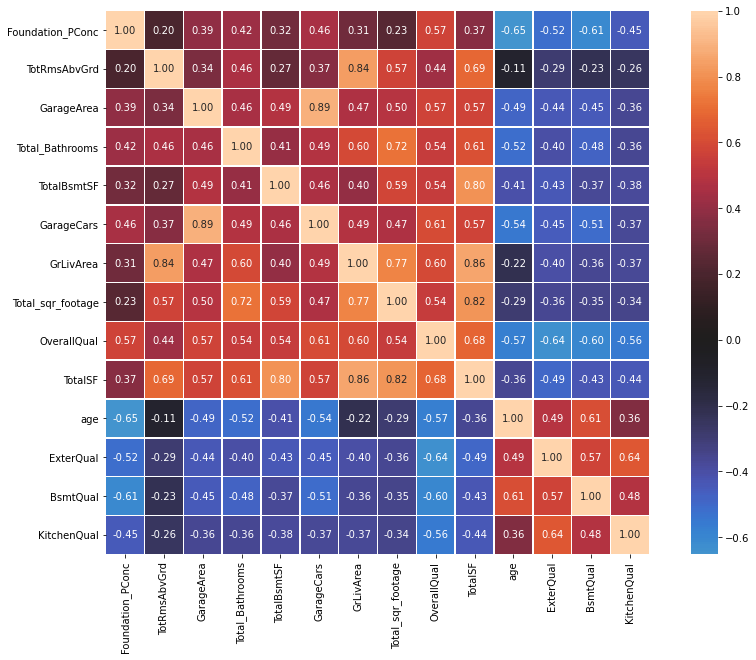

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(x.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True)
 #removing anything that has correlation of above 0.8

In [20]:
#remove one from (GrLivArea, TotRmsAbvGrd), (GarageArea, GarageCars), (TotalSF, TotalBsmtSF)
# (TotalSF, GrLivArea), (TotalSF, Total_sqr_footage)
x = x.drop(columns=['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF', 'Total_sqr_footage'])

<AxesSubplot:>

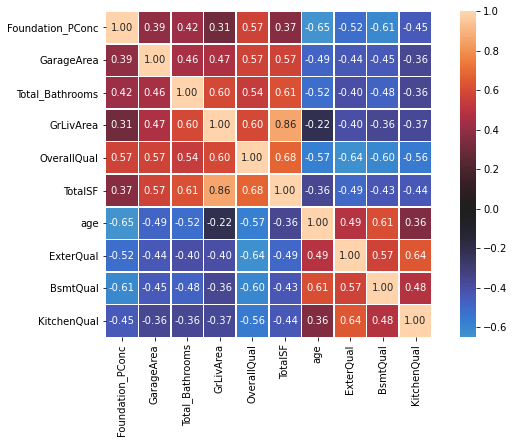

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(x.corr(), vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True)

In [22]:
x = x.drop(columns=['GrLivArea']) #remove ground living area
x.corr()

,Foundation_PConc,GarageArea,Total_Bathrooms,OverallQual,TotalSF,age,ExterQual,BsmtQual,KitchenQual
Foundation_PConc,1.000000,0.394454,0.424516,0.569206,0.367663,-0.652141,-0.515151,-0.611473,-0.449927
GarageArea,0.394454,1.000000,0.457214,0.567857,0.573070,-0.486749,-0.435412,-0.445804,-0.360925
Total_Bathrooms,0.424516,0.457214,1.000000,0.541639,0.612892,-0.522929,-0.398576,-0.476961,-0.355801
OverallQual,0.569206,0.567857,0.541639,1.000000,0.682481,-0.574238,-0.638627,-0.602190,-0.558793
TotalSF,0.367663,0.573070,0.612892,0.682481,1.000000,-0.364128,-0.491342,-0.431938,-0.442791
age,-0.652141,-0.486749,-0.522929,-0.574238,-0.364128,1.000000,0.492245,0.609128,0.358321
ExterQual,-0.515151,-0.435412,-0.398576,-0.638627,-0.491342,0.492245,1.000000,0.572327,0.641584
BsmtQual,-0.611473,-0.445804,-0.476961,-0.602190,-0.431938,0.609128,0.572327,1.000000,0.484650
KitchenQual,-0.449927,-0.360925,-0.355801,-0.558793,-0.442791,0.358321,0.641584,0.484650,1.000000


In [39]:
x.head(10)

,Foundation_PConc,GarageArea,Total_Bathrooms,OverallQual,TotalSF,age,ExterQual,BsmtQual,KitchenQual
Id,,,,,,,,,
1,1,548.0,3.5,7.0,2566.0,5.0,2,2,2
2,0,460.0,2.5,6.0,2524.0,31.0,3,2,3
3,1,608.0,3.5,7.0,2706.0,7.0,2,2,2
4,0,642.0,2.0,7.0,2473.0,91.0,3,4,2
5,1,836.0,3.5,8.0,3343.0,8.0,2,2,2
6,0,480.0,2.5,5.0,2158.0,16.0,3,2,3
7,1,636.0,3.0,8.0,3380.0,3.0,2,0,2
8,0,484.0,3.5,7.0,3197.0,36.0,3,2,3
9,0,468.0,2.0,7.0,2726.0,77.0,3,4,3


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=42) #removing random state increases r-square 

In [24]:
x_2=data2[['Foundation_PConc', 'GarageArea', 'Total_Bathrooms', 'OverallQual', 'TotalSF', 'age', 'ExterQual', 'BsmtQual', 'KitchenQual']]

In [25]:
#Linear Regression
regressor = LinearRegression()
regressor.fit(x_train, np.log(y_train/100000))
y_pred=regressor.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred))
y_pred=regressor.predict(x_2)
print(y_pred)
my_submission = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred)})
my_submission.to_csv('reg_submission.csv', index=False)

Mean Absolute Error: 0.11468818605423756
Mean Squared Error: 0.027595297448952522
Root Mean Squared Error: 0.16611832363996612
R-squared Error: 0.8521259461370034
[0.19532074 0.42130136 0.47351188 ... 0.3675129  0.14806787 0.77699277]


In [26]:
#random forest classifier
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor(random_state=42, n_estimators=65)
RandomForest.fit(x_train, np.log(y_train/100000))
y_pred_rand=RandomForest.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_rand))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_rand)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_rand))
y_pred_rand_sub=RandomForest.predict(x_2)
print(y_pred_rand_sub)
my_submission_rand = pd.DataFrame({'Id': data2.index, 'SalePrice': 100000*np.exp(y_pred_rand_sub)})
my_submission_rand.to_csv('rand_submission.csv', index=False)

Mean Absolute Error: 0.10993334774020425
Mean Squared Error: 0.026876237390662954
Root Mean Squared Error: 0.16393973707025078
R-squared Error: 0.8559791506906755
[0.21381951 0.4035611  0.46606325 ... 0.39269458 0.09304273 0.76526035]


In [28]:
results = pd.concat([my_submission['SalePrice'], my_submission_rand['SalePrice']], axis=1)
results.head(20)

,SalePrice,SalePrice
0,121570.084349,123839.911903
1,152394.345949,149714.670573
2,160562.305858,159370.779681
3,176441.156278,185828.599482
4,203996.529946,197265.547651
5,166893.959808,178289.496590
6,168813.982318,176851.061922
7,160492.056402,178330.643263
8,198348.292695,206326.059131
9,114286.556832,120947.896046


In [29]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(x_train,np.log(y_train/100000))
y_pred_dt=dt.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_dt))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_dt)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_dt))

Mean Absolute Error: 0.13187726778321737
Mean Squared Error: 0.03667342336323683
Root Mean Squared Error: 0.19150306358707903
R-squared Error: 0.8034792778810358


In [35]:
#Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(kernel='rbf', gamma='scale')
svr.fit(x_train,np.log(y_train/100000))
y_pred_svr=svr.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(np.log(y_test/100000), y_pred_svr))
print('Mean Squared Error:', metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log(y_test/100000), y_pred_svr)))
print('R-squared Error:', metrics.r2_score(np.log(y_test/100000), y_pred_svr))

Mean Absolute Error: 0.13880903006738787
Mean Squared Error: 0.040344501645783175
Root Mean Squared Error: 0.20085940766064003
R-squared Error: 0.7838071859714361
